In [2]:
# minor annoyance that I still don't get
import sys
sys.path.append('..')

import pandas as pd

from ift6758.pipeline import ExperimentPipeline, DEFAULT_TRANSFORMATIONS
from importlib import reload 
import ift6758.pipeline

In [3]:
reload(ift6758.pipeline.features)

from ift6758.pipeline.features import (
    mirror_coordinates,
    append_shot_angle,
    append_shot_distance,
    replace_nan_by_0,
    append_game_secs,
    append_time_lapse_prev,
    append_dist_prev,
    append_rebound,
    append_angle_change,
    append_speed
)

In [7]:
%%time
trans = [
    mirror_coordinates,
    append_shot_angle,
    append_shot_distance,
    replace_nan_by_0,
    append_game_secs,
    append_time_lapse_prev,
    append_dist_prev,
    append_rebound,
    append_angle_change,
    append_speed
]
df = ExperimentPipeline.get_data('../data/tabular', transformations=trans)
df.head()

fetching dataframes from ../data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
applying append_game_secs
applying append_time_lapse_prev
applying append_dist_prev
applying append_rebound
applying append_angle_change
applying append_speed
CPU times: user 5.12 s, sys: 469 ms, total: 5.59 s
Wall time: 6.47 s


,Unnamed: 0,game_starttime,game_endtime,game_id,datetime,offense_team_id,offense_team_name,offense_team_tricode,goal,x_coords,...,strength_powerplay,season,shot_angle,shot_distance,game_secs,time_lapsed_prev_event_in_seconds,dist_prev_event,rebound,angle_change,speed
0,0,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,0,2016-10-12T23:19:59Z,10,Toronto Maple Leafs,TOR,0,77.0,...,0.0,20162017,67.380135,13.000000,71,0,138.924440,False,None,inf
1,1,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,0,2016-10-12T23:21:41Z,9,Ottawa Senators,OTT,0,86.0,...,0.0,20162017,12.994617,13.341664,173,0,36.715120,False,None,inf
2,2,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,0,2016-10-12T23:23:17Z,9,Ottawa Senators,OTT,0,23.0,...,0.0,20162017,60.068488,76.157731,241,18,102.318131,False,None,5.684341
3,3,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,0,2016-10-12T23:24:02Z,9,Ottawa Senators,OTT,0,33.0,...,0.0,20162017,75.004921,57.974132,286,19,45.880279,False,None,2.414752
4,4,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,0,2016-10-12T23:27:30Z,10,Toronto Maple Leafs,TOR,0,34.0,...,0.0,20162017,63.019769,61.717096,406,15,63.348244,False,None,4.223216


In [4]:
# # FOR COMET LOGGING
# import os
# from getpass import getpass
#
# os.environ['COMET_API_KEY'] = getpass()

In [8]:
from sklearn.linear_model import LogisticRegression

pipeline = ExperimentPipeline(
    tabular_dir='../data/tabular',
    feature_columns=['shot_distance'],
    target_column='goal',
    pipeline_steps=[
        ('logreg', LogisticRegression()),
    ],
    dataset_transformations=DEFAULT_TRANSFORMATIONS,
    parameter_grid=[
        {'logreg__penalty': ['l2'], 'logreg__C': [1]},
    ],
    metric='accuracy',
    enable_comet=False
)

In [9]:
pipeline.run()

fetching dataframes from ../data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.5s
[CV 2/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.5s
[CV 3/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.4s
[CV 4/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.4s
[CV 5/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.5s


In [10]:
accuracy = pipeline.grid.best_score_
f'Best accuracy: {accuracy:.4f}'

'Best accuracy: 0.9051'

In [30]:
x_train, y_train = pipeline.dataset['x_train'], pipeline.dataset['y_train']
x_test, y_test = pipeline.dataset['x_test'], pipeline.dataset['y_test']
best_model = pipeline.grid.best_estimator_

preds = best_model.predict(x_test)


NameError: name 'confusion_matrix' is not defined

In [12]:
pd.Series(preds).value_counts()

0    89584
dtype: int64

Our model always predicts the majority class, meaning the failed shot. We need to adjust our metric to consider this imbalance

In [13]:
import numpy as np

class UniformClassifier:
    def predict(self, x):
        return (self.predict_proba(x) > 0.5).astype(int)

    def predict_proba(self, x):
        np.random.seed(42)
        m, n = x.shape
        p = np.random.rand(m)
        return np.array([p, 1-p]).T

baseline = UniformClassifier()

In [14]:
model_results = [
    (y_test, best_model.predict_proba(x_test)[:,1], 'best_model'),
    (y_test, baseline.predict_proba(x_test)[:,1], 'baseline')
]

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc(models):
    for truth, preds, label in models:
        fpr, tpr, _ = roc_curve(truth, preds)
        auc = roc_auc_score(truth, preds)

        plt.plot(fpr, tpr, label=f'{label}, AUC={auc:.3f}')

    plt.grid()
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.legend()
    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.title('ROC curve')
    plt.show()

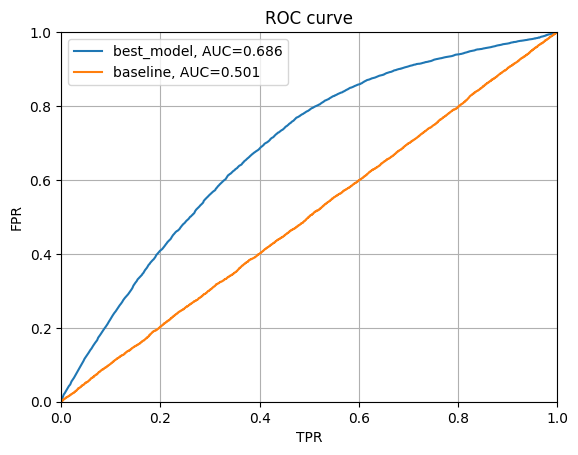

In [16]:
plot_roc(model_results)

In [17]:
def plot_goal_rate(models):
    for truth, preds, label in models:
        df = pd.DataFrame({'probability': preds, 'goal': truth})
        percentiles = pd.qcut(df['probability'], q=100, duplicates='drop')
        goal_rate = df.groupby(percentiles).goal.mean()

        plt.plot(list(range(len(percentiles.unique()))), goal_rate, label=label)

    plt.ylim((0,1))
    plt.xlim((0,100))
    plt.xlabel('Model predicted shot probability percentile')
    plt.ylabel('Goal rate')
    plt.grid()
    plt.legend()
    plt.title('Goal rate by Probability percentile')
    plt.show()

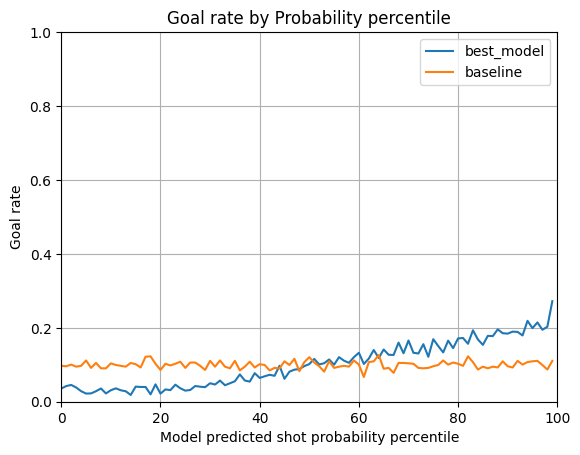

In [18]:
plot_goal_rate(model_results)

In [19]:
def plot_goal_cumsum(models):
    for truth, preds, label in models:
        df = pd.DataFrame({'probability': preds, 'goal': truth})
        percentiles = pd.qcut(df['probability'], q=100, duplicates='drop')
        grouped_goals = df.groupby(percentiles).goal.sum()
        proportion_goals = grouped_goals.cumsum() / grouped_goals.sum()

        plt.plot(list(range(len(percentiles.unique()))), proportion_goals, label=label)

    plt.ylim((0,1))
    plt.xlim((0,100))
    plt.xlabel('Model predicted shot probability percentile')
    plt.ylabel('Proportion')
    plt.grid()
    plt.legend()
    plt.title('Proportion of goals by Probability percentile')
    plt.show()

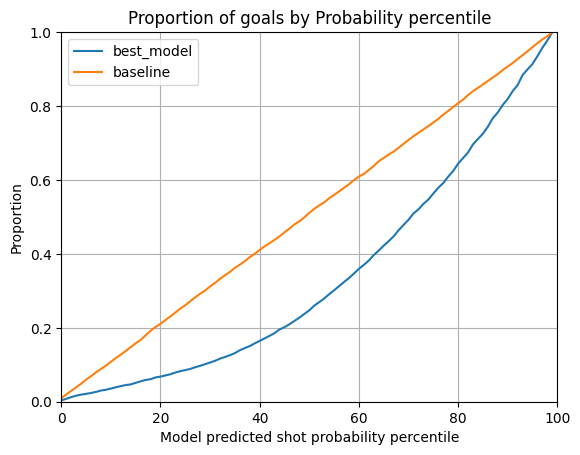

In [20]:
plot_goal_cumsum(model_results)

In [21]:
from sklearn.calibration import CalibrationDisplay
def plot_calibration(models):
    ax = plt.gca()
    for truth, preds, label in models:
        CalibrationDisplay.from_predictions(truth, preds, ax=ax, n_bins=40, label=label)

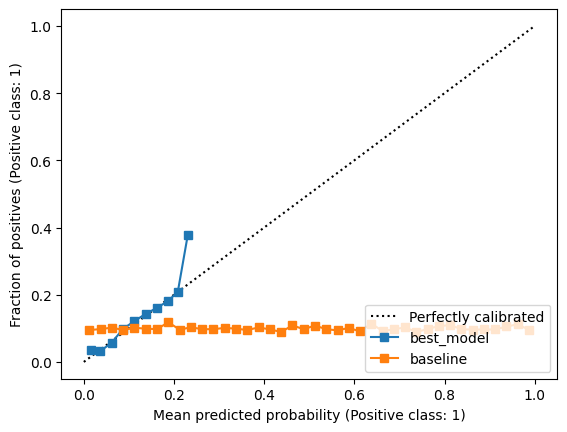

In [22]:
plot_calibration(model_results)

In [23]:
DEFAULT_PARAMETERS = {
    'tabular_dir': '../data/tabular',
    'feature_columns': ['shot_distance'],
    'target_column': 'goal',
    'pipeline_steps': [
        ('logreg', LogisticRegression()),
    ],
    'dataset_transformations': DEFAULT_TRANSFORMATIONS,
    'parameter_grid': [
        {'logreg__penalty': ['l2'], 'logreg__C': [1]},
    ],
    'metric': 'accuracy',
    'enable_comet': False
}

In [24]:
model_results = [(y_test, baseline.predict_proba(x_test)[:,1], 'baseline')]

In [25]:
for features in [
    ['shot_distance'],
    ['shot_angle'],
    ['shot_distance', 'shot_angle']
]:
    params = DEFAULT_PARAMETERS.copy()
    params['feature_columns'] = features

    pipeline = ExperimentPipeline(**params)
    pipeline.run()

    model_results.append(
        (
            pipeline.dataset['y_test'],
            pipeline.get_test_probas()[:,1],
            str(features)
        )
    )

fetching dataframes from ../data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.6s
[CV 2/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.8s
[CV 3/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   1.2s
[CV 4/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   1.0s
[CV 5/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.9s
fetching dataframes from ../data/tabular
applying mirror_coordinates
applying append_shot_angle
applying append_shot_distance
applying replace_nan_by_0
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   0.8s
[CV 2/5] END ...logreg__C=1, logreg__penalty=l2;, score=0.905 total time=   1.1s
[CV 3/5] EN

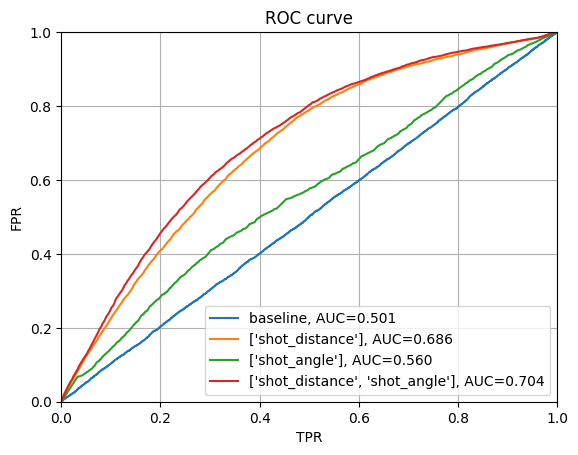

In [26]:
plot_roc(model_results)

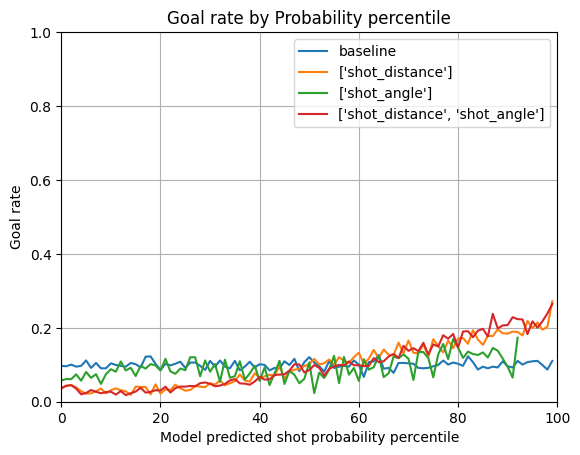

In [27]:
plot_goal_rate(model_results)

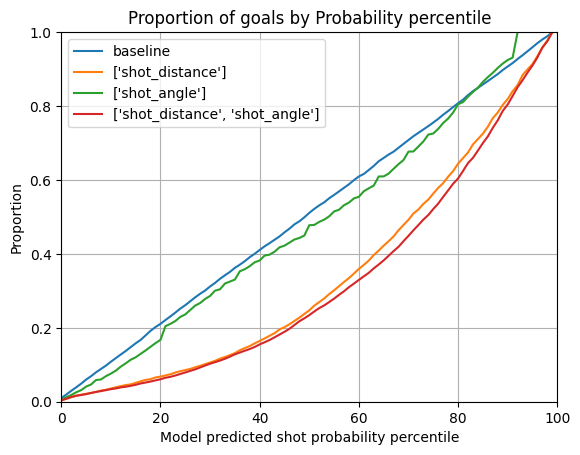

In [28]:
plot_goal_cumsum(model_results)

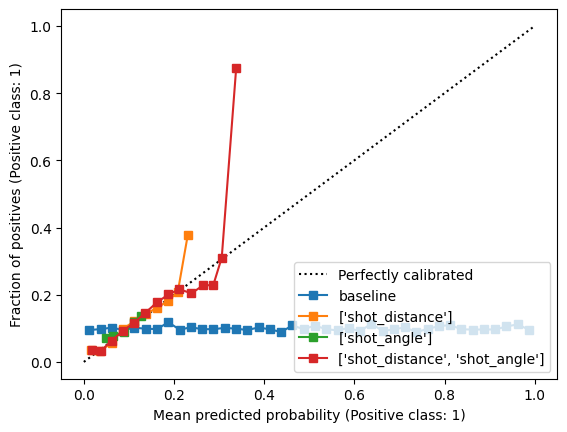

In [29]:
plot_calibration(model_results)